In [1]:
import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text

In [2]:
import tensorflow_text as text

In [6]:
import pandas as pd
df=pd.read_csv(r"Files/spam.csv", encoding = "ISO-8859-1", engine = "python")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [8]:
for col in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']:
    df=df.drop(col,axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.rename(columns={'v1':'Category','v2':'Message'},inplace=True)

In [12]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [13]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [14]:
747/4825

0.15481865284974095

In [15]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [16]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [17]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [18]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [19]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [20]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1573,spam,SMS AUCTION - A BRAND NEW Nokia 7250 is up 4 a...,1
3583,spam,Hi 07734396839 IBH Customer Loyalty Offer: The...,1
683,spam,Hi I'm sue. I am 20 years old and work as a la...,1
1437,ham,Wat so late still early mah. Or we juz go 4 di...,0
3895,spam,tells u 2 call 09066358152 to claim å£5000 pri...,1


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [22]:
X_train.head(4)

4768    watever reLation u built up in dis world only ...
1503                      Ill be there on  &lt;#&gt;  ok.
1193    Sex up ur mobile with a FREE sexy pic of Jorda...
4416     says that he's quitting at least5times a day ...
Name: Message, dtype: object

In [23]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [24]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.8884573 , ..., -0.74748886,
        -0.75314736,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.858475  ,
        -0.7174534 ,  0.88082975]], dtype=float32)>

In [25]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911087]], dtype=float32)

In [27]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703815]], dtype=float32)

In [28]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720336]], dtype=float32)

In [29]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [31]:
len(X_train)

1120

In [32]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [33]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 206s 6s/step - loss: 0.6482 - accuracy: 0.6509 - precision: 0.6501 - recall: 0.6536
Epoch 2/10
35/35 [==============================] - 194s 6s/step - loss: 0.5158 - accuracy: 0.8107 - precision: 0.8021 - recall: 0.8250
Epoch 3/10
35/35 [==============================] - 194s 6s/step - loss: 0.4487 - accuracy: 0.8438 - precision: 0.8348 - recall: 0.8571
Epoch 4/10
35/35 [==============================] - 197s 6s/step - loss: 0.4055 - accuracy: 0.8589 - precision: 0.8526 - recall: 0.8679
Epoch 5/10
35/35 [==============================] - 196s 6s/step - loss: 0.3721 - accuracy: 0.8795 - precision: 0.8596 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 199s 6s/step - loss: 0.3432 - accuracy: 0.8893 - precision: 0.8785 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 196s 6s/step - loss: 0.3283 - accuracy: 0.8911 - precision: 0.8737 - recall: 0.9143
Epoch 8/10
35/35 [==============================

In [34]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 66s 5s/step - loss: 0.2752 - accuracy: 0.9037 - precision: 0.8995 - recall: 0.9091


[0.27524176239967346,
 0.903743326663971,
 0.8994709253311157,
 0.9090909361839294]

In [35]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 61s 5s/step


In [36]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[168,  19],
       [ 17, 170]], dtype=int64)

Text(33.0, 0.5, 'Truth')

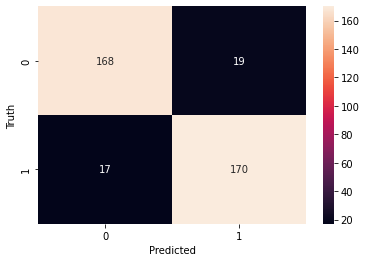

In [38]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       187
           1       0.90      0.91      0.90       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



In [40]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.7574865 ],
       [0.7984654 ],
       [0.74362016],
       [0.1780435 ],
       [0.09141795]], dtype=float32)